In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline 
import matplotlib.pyplot as plt
import dask
import dask.dataframe as dd

#### Import my subset using Dask

In [22]:
#my subset
df1 = dd.read_csv('accepted_2007_to_2018Q4.csv', usecols=['acc_now_delinq','acc_open_past_24mths','addr_state','all_util',
                'annual_inc','annual_inc_joint','application_type','avg_cur_bal',
                'bc_open_to_buy','bc_util','chargeoff_within_12_mths','collection_recovery_fee',
                'collections_12_mths_ex_med','debt_settlement_flag','debt_settlement_flag_date',
                'deferral_term','delinq_2yrs','delinq_amnt','disbursement_method',
                'dti','dti_joint','earliest_cr_line','emp_length','emp_title',
                'fico_range_high','fico_range_low','funded_amnt','funded_amnt_inv',
                'grade','int_rate','loan_status','issue_d'], low_memory = False)

#### Only use years 2015-2018

In [23]:
df1['issue_d']=dd.to_datetime(df1.issue_d)

In [24]:
df1 = df1.loc[df1['issue_d'].dt.year.between(2015,2018)]

In [25]:
df1['issue_d'].value_counts().compute()

2016-03-01    61992
2015-10-01    48631
2018-05-01    46311
2018-10-01    46305
2018-08-01    46079
2015-07-01    45962
2015-12-01    44343
2017-08-01    43573
2018-07-01    43089
2018-04-01    42928
2017-11-01    42343
2018-11-01    41973
2018-06-01    41533
2018-12-01    40134
2017-09-01    39713
2016-02-01    39529
2017-07-01    39415
2018-09-01    39026
2018-03-01    38771
2017-12-01    38154
2017-10-01    38151
2017-06-01    38087
2017-05-01    37681
2015-11-01    37530
2017-03-01    37181
2016-04-01    36432
2018-01-01    36347
2016-08-01    36280
2016-12-01    36183
2015-08-01    35886
2015-04-01    35427
2015-01-01    35107
2016-07-01    34696
2016-11-01    34591
2016-06-01    33019
2016-10-01    32772
2018-02-01    32746
2016-01-01    32366
2015-05-01    31913
2017-01-01    31835
2017-04-01    29683
2015-09-01    28641
2015-06-01    28485
2016-05-01    28403
2016-09-01    28144
2017-02-01    27763
2015-03-01    25400
2015-02-01    23770
Name: issue_d, dtype: int64

In [26]:
# If there is no issue date, this is not a "good" record

In [27]:
df1 = df1.dropna(subset=['issue_d'])

#### Drop
- grades G and F
- features not available at origination of loan

In [28]:
df1 = df1[(df1.grade != 'F') & (df1.grade != 'G')]

In [29]:
#add 'desc' to list
df1 = df1.drop(['collection_recovery_fee','debt_settlement_flag','debt_settlement_flag_date','deferral_term','funded_amnt','funded_amnt_inv'], axis=1)

## Evaluate each feature

In [10]:
df1['acc_now_delinq'].value_counts().compute()

0.0     1750076
1.0        6467
2.0         317
3.0          37
4.0           7
6.0           2
14.0          1
7.0           1
5.0           1
Name: acc_now_delinq, dtype: int64

In [11]:
sum(df1['acc_now_delinq'].isnull().compute())

0

In [12]:
df1['acc_open_past_24mths'].describe().compute()

count    1.756909e+06
mean     4.559388e+00
std      3.213900e+00
min      0.000000e+00
25%      2.000000e+00
50%      4.000000e+00
75%      6.000000e+00
max      6.400000e+01
Name: acc_open_past_24mths, dtype: float64

In [13]:
sum(df1['acc_open_past_24mths'].isnull().compute())

0

### State

In [14]:
df1.addr_state.value_counts().compute()

CA    238127
TX    146874
NY    142953
FL    127698
IL     71141
NJ     63845
PA     59292
OH     58674
GA     57831
NC     48899
VA     47602
MI     46205
AZ     42249
MD     42072
MA     39949
CO     37649
WA     35748
MN     30701
IN     30325
TN     28833
CT     28020
MO     28007
NV     25589
WI     23510
SC     21896
AL     20902
OR     20437
LA     19814
KY     17095
OK     16206
KS     14657
AR     13259
UT     11330
MS     11151
NM      9192
NH      8757
HI      7924
RI      7792
NE      7650
WV      5827
DE      5076
ME      4878
MT      4798
ID      4224
VT      3949
AK      3896
DC      3863
WY      3541
ND      3514
SD      3488
Name: addr_state, dtype: int64

In [15]:
sum(df1['addr_state'].isnull().compute())

0

In [16]:
#NEED TO DUMMIFY

### Balance to credit limit on all trades

In [17]:
sum(df1['all_util'].isnull().compute())

388531

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'Fully Paid'),
  Text(1, 0, 'Current'),
  Text(2, 0, 'Charged Off'),
  Text(3, 0, 'In Grace Period'),
  Text(4, 0, 'Late (31-120 days)'),
  Text(5, 0, 'Late (16-30 days)'),
  Text(6, 0, 'Default')])

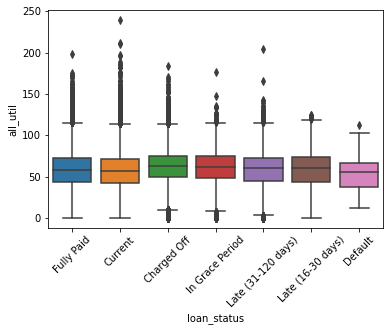

In [18]:
util_box = df1[['loan_status', 'all_util']].dropna().compute()
sns.boxplot(x='loan_status', y="all_util", data=util_box)
plt.xticks(rotation=45)

In [19]:
df1['all_util'].mean().compute()

56.83556298040454

In [41]:
df1.all_util = df1.all_util.fillna(np.mean(df1.all_util))

In [42]:
sum(df1['all_util'].isnull().compute())

0

### Annual Income

- 94% missing in annual_inc_joint

In [30]:
#create new feature combining annual_inc and annual_inc_joint
df1['annual_inc_total'] = df1['annual_inc_joint'].fillna(df1['annual_inc'])

In [22]:
sum(df1['annual_inc_total'].isnull().compute())

0

<AxesSubplot:xlabel='annual_inc_total', ylabel='int_rate'>

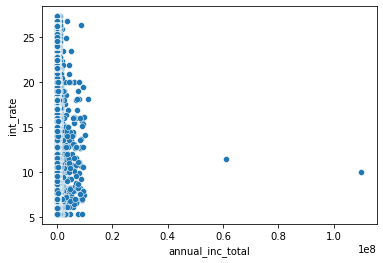

In [23]:
sns.scatterplot(x='annual_inc_total',y='int_rate', data=df1.compute())

In [24]:
df1['annual_inc_total'].describe().compute()

count    1.756909e+06
mean     8.366654e+04
std      1.255351e+05
min      1.900000e+03
25%      5.200000e+04
50%      7.500000e+04
75%      1.100000e+05
max      1.100000e+08
Name: annual_inc_total, dtype: float64

In [31]:
#Drop 2 outliers
df1= df1[df1.annual_inc_total < .2e8]

<AxesSubplot:xlabel='annual_inc_total', ylabel='int_rate'>

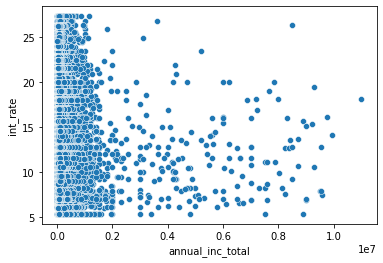

In [26]:
sns.scatterplot(x='annual_inc_total',y='int_rate', data=df1.compute())

In [32]:
#drop annual inc and annual inc joint
df1 = df1.drop(['annual_inc','annual_inc_joint'], axis=1)

#### Application Type

In [28]:
df1['application_type'].value_counts().compute()

Individual    1638772
Joint App      118135
Name: application_type, dtype: int64

In [33]:
#covert to binary
import dask.array as da
x= df1['application_type'].to_dask_array()
df1['application_type_indiv']= da.where(x =='Individual',1,0)

In [30]:
df1['application_type_indiv'].value_counts().compute()

1    1638772
0     118135
Name: application_type_indiv, dtype: int64

In [34]:
#drop application column
df1 = df1.drop('application_type', axis=1)

In [32]:
sum(df1['application_type_indiv'].isnull().compute())

0

#### Average current balance of all accounts

In [33]:
df1['avg_cur_bal'].describe().compute()

count    1.756852e+06
mean     1.358154e+04
std      1.659573e+04
min      0.000000e+00
25%      3.406000e+03
50%      7.982000e+03
75%      1.952550e+04
max      7.529940e+05
Name: avg_cur_bal, dtype: float64

In [35]:
sum(df1['avg_cur_bal'].isnull().compute())

55

In [37]:
df1 = df1.dropna(subset=['avg_cur_bal'])

In [38]:
sum(df1['avg_cur_bal'].isnull().compute())

0

In [35]:
df1[['loan_status', 'avg_cur_bal']].dropna().groupby('loan_status').mean().compute()

,avg_cur_bal
loan_status,
Charged Off,10872.912693
Current,13671.719193
Default,12771.368421
Fully Paid,14214.878308
In Grace Period,14057.718726
Late (16-30 days),12798.756980
Late (31-120 days),12094.687158


(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'Fully Paid'),
  Text(1, 0, 'Current'),
  Text(2, 0, 'Charged Off'),
  Text(3, 0, 'In Grace Period'),
  Text(4, 0, 'Late (31-120 days)'),
  Text(5, 0, 'Late (16-30 days)'),
  Text(6, 0, 'Default')])

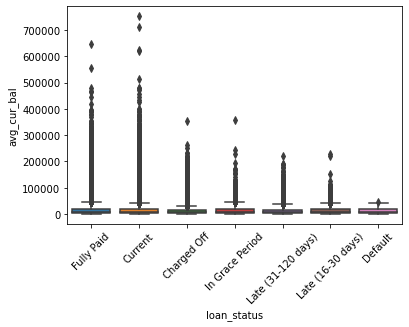

In [36]:
cur_bal_box = df1[['loan_status', 'avg_cur_bal']].dropna().compute()
sns.boxplot(x='loan_status', y='avg_cur_bal', data=cur_bal_box)
plt.xticks(rotation=45)

In [37]:
#log?

#### Total open to buy on revolving bankcards

In [38]:
df1['bc_open_to_buy'].value_counts().compute()

0.0         21305
2000.0       1536
500.0        1515
1000.0       1361
3000.0       1307
            ...  
75413.0         1
75412.0         1
75411.0         1
75409.0         1
711140.0        1
Name: bc_open_to_buy, Length: 88934, dtype: int64

In [39]:
sum(df1['bc_open_to_buy'].isnull().compute())

20182

#### Ratio of total current balance to high credit/credit limit for all bankcard accounts.

In [40]:
df1['bc_util'].value_counts().compute()

0.0      23883
98.0      4941
99.0      4546
97.0      4523
96.0      4471
         ...  
156.2        1
155.5        1
154.9        1
154.4        1
318.2        1
Name: bc_util, Length: 1445, dtype: int64

In [41]:
sum(df1['bc_util'].isnull().compute())

21034

#### # of chargeoffs & # of collections

In [42]:
df1['chargeoff_within_12_mths'].value_counts().compute()

0.0     1743147
1.0       12708
2.0         794
3.0         151
4.0          61
5.0          20
6.0          11
7.0           7
9.0           5
8.0           2
10.0          1
Name: chargeoff_within_12_mths, dtype: int64

In [43]:
sum(df1['chargeoff_within_12_mths'].isnull().compute())

0

In [44]:
df1['collections_12_mths_ex_med'].value_counts().compute()

0.0     1724125
1.0       30330
2.0        2052
3.0         246
4.0          83
5.0          34
6.0          15
7.0           7
9.0           4
8.0           4
12.0          2
10.0          2
20.0          1
14.0          1
11.0          1
Name: collections_12_mths_ex_med, dtype: int64

In [45]:
sum(df1['collections_12_mths_ex_med'].isnull().compute())

0

- 99%, 98% of non-null values are 0 
- both have 141 missings - drop

### DELINQ

In [46]:
sum(df1['delinq_2yrs'].isnull().compute())

0

In [47]:
sum(df1['delinq_amnt'].isnull().compute())

0

#### Disbursement method

In [48]:
df1['disbursement_method'].value_counts().compute()

Cash         1679433
DirectPay      77474
Name: disbursement_method, dtype: int64

In [49]:
#covert to binary
#import dask.array as da
x = df1['disbursement_method'].to_dask_array()
df1['disbursement_method_cash']= da.where(x =='Cash',1,0)

In [50]:
df1['disbursement_method_cash'].value_counts().compute()

1    1679433
0      77474
Name: disbursement_method_cash, dtype: int64

In [51]:
#drop original column
df1 = df1.drop('disbursement_method', axis=1)

In [52]:
sum(df1['disbursement_method_cash'].isnull().compute())

0

#### DTI

In [53]:
sum(df1['dti'].isnull().compute())

1666

In [54]:
df1['dti'].value_counts().compute()

0.00      1338
16.80     1198
18.00     1192
19.20     1166
14.40     1151
          ... 
100.17       1
100.18       1
100.22       1
100.23       1
72.51        1
Name: dti, Length: 10744, dtype: int64

In [55]:
df1['dti_joint'].value_counts().compute()

17.32    76
17.96    76
19.89    76
22.39    75
16.97    75
         ..
46.52     1
46.83     1
46.86     1
48.58     1
69.49     1
Name: dti_joint, Length: 4014, dtype: int64

In [56]:
sum(df1['dti_joint'].isnull().compute())

1638776

- 94% missing - impute 0 for not joint?

#### Earliest reported credit line opened

In [57]:
df1['earliest_cr_line'].value_counts().compute()

Sep-2004    12853
Sep-2005    12642
Sep-2003    12319
Aug-2005    12229
Aug-2006    12168
            ...  
Nov-1952        1
May-1958        1
Jan-1948        1
Mar-1958        1
Jan-1944        1
Name: earliest_cr_line, Length: 737, dtype: int64

In [58]:
#need to change format
df1['earliest_cr_line']=dd.to_datetime(df1.earliest_cr_line,unit='ns')

In [59]:
df1['earliest_cr_line'].value_counts().compute()

2004-09-01    12853
2005-09-01    12642
2003-09-01    12319
2005-08-01    12229
2006-08-01    12168
              ...  
1959-04-01        1
1955-06-01        1
1955-08-01        1
1960-11-01        1
1933-03-01        1
Name: earliest_cr_line, Length: 737, dtype: int64

In [60]:
sum(df1['earliest_cr_line'].isnull().compute())

0

### Professions

- need to deal with emp_title

In [61]:
df1['emp_length'].value_counts().compute()

10+ years    585596
2 years      158869
< 1 year     150740
3 years      141066
1 year       116276
5 years      106598
4 years      106326
6 years       74858
8 years       67893
7 years       65050
9 years       60101
Name: emp_length, dtype: int64

In [62]:
#covert to ordinal
#subset.emp_length.replace({'< 1 year':0, '1 year':1, '2 years':2, '3 years':3,'4 years':4, '5 years':5, '6 years':6, '7 years':7, '8 years':8, '9 years':9, '10+ years':10}, inplace=True)

In [63]:
sum(df1['emp_length'].isnull().compute())

123534

### Fico

In [64]:
df1['fico_range_high'].describe().compute()

count    1.756907e+06
mean     7.036037e+02
std      3.366068e+01
min      6.640000e+02
25%      6.840000e+02
50%      7.040000e+02
75%      7.340000e+02
max      8.500000e+02
Name: fico_range_high, dtype: float64

In [65]:
sum(df1['fico_range_high'].isnull().compute())

0

In [66]:
sum(df1['fico_range_low'].isnull().compute())

0

### Grade 

In [67]:
df1['grade'].value_counts().compute()

B    526608
C    524739
A    358156
D    247524
E     99880
Name: grade, dtype: int64

In [68]:
sum(df1['grade'].isnull().compute())

0

<AxesSubplot:xlabel='grade', ylabel='int_rate'>

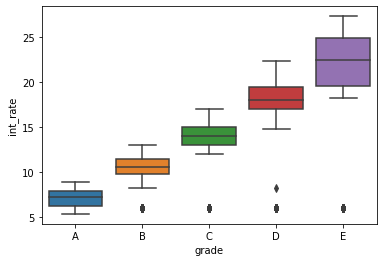

In [69]:
my_order = ['A','B','C','D','E']
sns.boxplot(x='grade', y='int_rate', data=df1.compute(), order=my_order)

In [70]:
#removed F & G at top

In [39]:
df1['grade'] = df1['grade'].mask(df1['grade'] == 'E', '1').mask(df1['grade'] == 'D', '2').mask(df1['grade'] == 'C', '3').mask(df1['grade'] == 'B', '4').mask(df1['grade'] == 'A', '5')


In [40]:
df1['grade'].value_counts().compute()

4    526594
3    524725
5    358154
2    247502
1     99877
Name: grade, dtype: int64